# Random Forest regressor example

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

#the following gives access to utils folder
#where utils package stores shared code
import os
import sys
PROJECT_ROOT = os.path.abspath(os.path.join(
                  os.getcwd(),
                  os.pardir)
)

#only add it once
if (PROJECT_ROOT not in sys.path):
    sys.path.append(PROJECT_ROOT)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

Generally a datascience problem starts with a question:
1. I want to buy a house in a very safe neighborhood for as little as possible.
2. I want to buy a house in a neighborhood that has the best chance of appreciation.

Then you find data that will help you answer questions. For instance;
1. You need crime records by zipcode/neighborhood and sales data, maybe generate a feature thats a combination of crime_score and average sales price. Output a list of safeest/lowest price neighborhoods
2. You need historical sales data (how far back is relevant?), information on schools including an unbiased rating, probably walkability indexes, proximity to hospital, traffic info.  Probably stiching together a lot of separate data sources.

We will do something a bit simpler here, just estimate a houses price based on a bunch of features


# Load Data


In [27]:
# !pip install wget

In [26]:
#get the data if you do not have it
import os
 
# Specify path
path='../datasets1'
file = '../datasets1/melb_data.csv'

#ceate if not there
if(not os.path.exists(path)):
    os.mkdir(path)
 
# Check whether file exists or not
if( not os.path.exists(file)):    
    import wget
    # Define the remote file to retrieve
    remote_url = 'https://raw.githubusercontent.com/CNUClasses/DATA301_CODE/master/datasets/melb_data.csv'
    # Define the local filename to save data
    local_file = file
    # Make http request for remote file data
    wget.download(remote_url, local_file)

100% [......................................................] 2091239 / 2091239

'../datasets1/melb_data.csv'

In [21]:
df = pd.read_csv("../datasets/melb_data.csv")
df.head()
print(f'there are {len(df)} rows in df')

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,2.0,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,2.0,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,3.0,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,3.0,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


there are 13580 rows in df


## BTW if you are doing EDA or model building AND your dataset is large then work with a randomly sampled fraction of the data.

This will hugely speed up EDA and model training.  You should do this every time when you first start working with a dataset, especially if it's a large one.

<mark>When you finish tuning, finding hyperparameters and such, then use the FULL dataset

In [3]:
#get a fraction (10%) of the data to work on
# df=df.sample( frac=.1, replace=False, weights=None, random_state=42).reset_index(drop=True)

#get 10 rows to work on (used to demonstrate MAE below)
# df=df.sample( n=10, replace=False, weights=None, random_state=42).reset_index(drop=True)

print(f'there are {len(df)} rows in df')

there are 1358 rows in df


## Preprocess?
Don't have to do much for random forest (convert strings to numbers) and handle nulls, treat all catagoricals as ordinal.  Dont worry about normalization 

## Clean up NaNs

In [4]:
#first are there any?
df.isnull().sum()

Suburb             0
Address            0
Rooms              0
Type               0
Price              0
Method             0
SellerG            0
Date               0
Distance           0
Postcode           0
Bedroom2           0
Bathroom           0
Car                4
Landsize           0
BuildingArea     647
YearBuilt        528
CouncilArea      134
Lattitude          0
Longtitude         0
Regionname         0
Propertycount      0
dtype: int64

In [5]:
def fix_nans(cols):
    for col in cols:
        def imputeval(df,targ_col,imput_col):
            #get average values based on imput_col
            sm=df.groupby(by=[imput_col])[targ_col].mean()

            #for a given row, look up and return the mean col
            def impute(x):
                return sm.loc[x[imput_col]]

            #replace NaNs with the average
            df[targ_col]=df.apply(lambda x:impute(x) if np.isnan(x[targ_col]) else x[targ_col],axis=1)

        imputeval(df,col,'Suburb')
        imputeval(df,col,'Postcode')
        #if here probably no good way to impute the remainders
        # dont want to drop them so set them to the column mean
        df[col]=df[col].fillna(df[col].mean())

fix_nans(cols=['YearBuilt','Landsize','BuildingArea'])

## Lets strip some columns to make this demo easier

In [6]:
#lets strip out just a few columns to make this example easier
# Choose target and features
features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea', 'Suburb','Postcode',
                        'YearBuilt', 'Lattitude', 'Longtitude']

#dependant variable (what you are estimating)
y = df.Price

#independant variables
df = df[features]

print(f'there are {len(df)} rows in df')

there are 1358 rows in df


In [7]:
#what types are we dealing with
df.dtypes

Rooms             int64
Bathroom        float64
Landsize        float64
BuildingArea    float64
Suburb           object
Postcode        float64
YearBuilt       float64
Lattitude       float64
Longtitude      float64
dtype: object

## Visualization: What can you tell by just plotting some stuff?

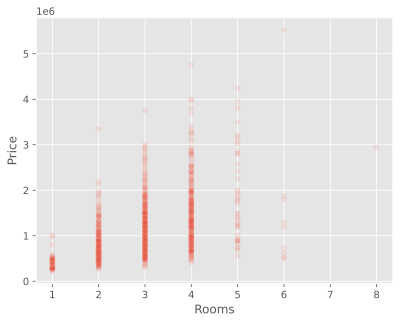

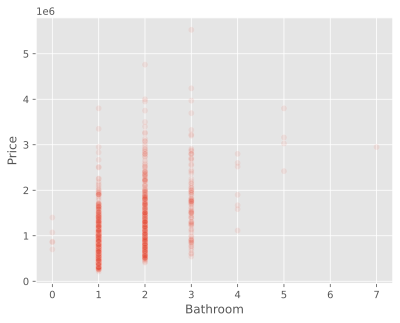

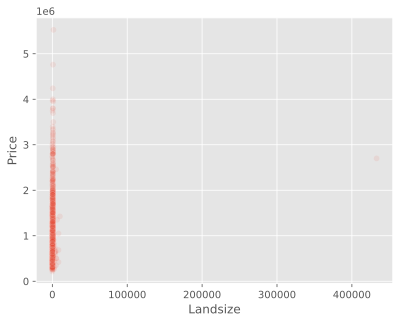

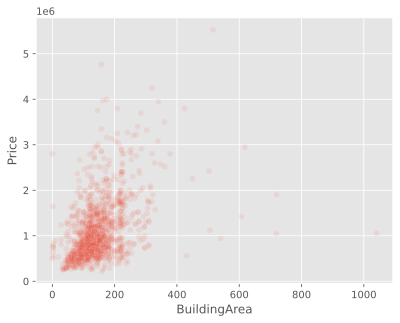

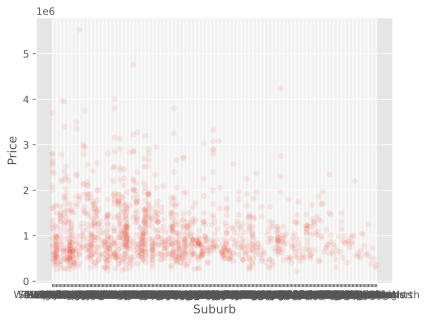

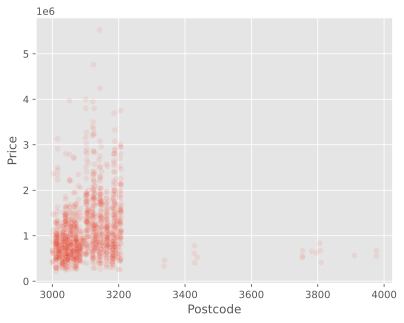

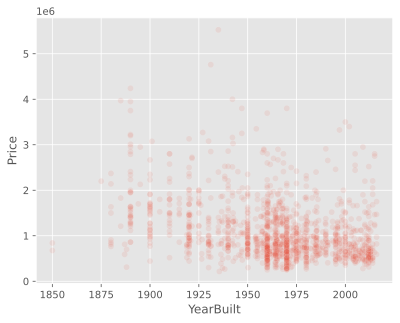

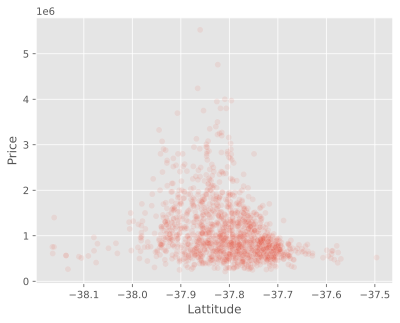

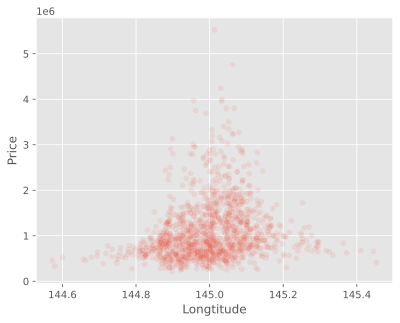

In [8]:
for col in features:
    _=plt.figure()
    _=sns.scatterplot(data=df,x=col,y=y, alpha=.1)

### From the above
1. I see most of the houses have between 2 and 5 rooms 
2. I also see most have between 1 and 3 bathrooms

My guess is the model will be best at predicting the price for houses 2-5 rooms and 1-3 bathrooms since there are so many examples for it to learn from

3. Landsize has some outliers, I'm sure the model will not do well predicting on houses that have land sizes>5000 since there are so few examples

4. Building area has outliers, either they are just wrong or its an apartment building mixed in with regular houses.  How will the model do here?

5. One YearBuilt is 1200AD. This is clearly wrong. (How would you fix this? See bottom of page)
6. Notice that column of YearBuilt values around  1975.  What do you think that means?
7. Lattitude and longitude tell you where most of the houses are.  What do you think would happen if you clustered this data?


## Remove the outliers to get better plots for Yearbuilt, BuildingArea and Landsize

In [9]:
#find and  set the bogus values to NaNs
df.loc[df['YearBuilt']<1700,'YearBuilt']=np.NaN
df.loc[df['BuildingArea']>1000,'BuildingArea']=np.NaN
df.loc[df['Landsize']>10000,'Landsize']=np.NaN

fix_nans(cols=['YearBuilt','Landsize','BuildingArea'])

In [10]:
#dont need Postcode
df.drop(columns=['Postcode'], inplace=True)
features = ['Rooms', 'Bathroom', 'Landsize', 'BuildingArea','Suburb' ,
                        'YearBuilt', 'Lattitude', 'Longtitude']

## Suburb probably captures excellent info about value, encode it

In [33]:
#utils.cat_ordinal would work fine with a mapping
#so generate a mapping
suburb_map={i:v for v,i in enumerate(list(df.Suburb.unique()))}
import utils as ut
order={'Suburb':suburb_map}
df=ut.cat_ordinal(df,['Suburb'],order)

In [34]:
df.dtypes

Rooms             int64
Bathroom        float64
Landsize        float64
BuildingArea    float64
Suburb            int64
YearBuilt       float64
Lattitude       float64
Longtitude      float64
dtype: object

# Analysis

How are we going to see if we are right?  We cannot use accuracy here like we did for classification since we are predicting a floating point number, and even if 2 floating point numbers are very close, in a boolean expression they will not be equal (ex 0.002 != 0.002001).

So what to do?  Measure the difference between the true value and the predicted value or each point, sum these differences, and then divide by the number of points.  This is called the <mark>mean_absolute_error</mark> and it's given by the formula below.
![](./mae_form.png)

A MAE of 0 means your model is perfect 

In [12]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(df, y,random_state = 0)

In [13]:
#BTW mean absolute error is simple, here is an implementation
def mae(val_y, predst):
    tots=0
    for y,p in zip(val_y, predst):
        tots=tots +np.abs(p-y)
    return tots/len(val_y)

#but you are better off using sklearns implementation (less code to write)
from sklearn.metrics import mean_absolute_error

### What's the average house price?

In [14]:
y.mean()

1080690.530927835

### Train a Decision tree Regressor (remember this is a single tree)

Scikitlearn estimators work the same way,;
1. Fit estimator to the training data
2. Generate predictions on validation data
3. Use an error metric to determine how good model is

In [15]:
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor

In [16]:
#1. Fit estimator to the training data


# 2. Generate predictions on validation data


# 3. Use an error metric to determine how good model is


301012.8058823529


In [17]:
#verify that home rolled mae is the same as sklearns mean_absolute_error
# print(f'mae error={mae(val_y, predst)}')

mae error=301012.8058823529


### Then train a random forest regressor (lots of decision trees)

#### A word about OOB error

You can use OOB score but scikitlearn RandomForestRegressor hardcodes the error metric to r2_score and  we want to use MAE so we will forgo OOB here.
You can see this hardcoding by creating the RandomForestRegressor and then looking at the source code for _set_oob_score_and_attributes
<code> 
from sklearn.ensemble import RandomForestRegressor
forest_model = RandomForestRegressor(random_state=42, oob_score=True)
forest_model._set_oob_score_and_attributes??
</code>

In [18]:
#1. Fit estimator to the training data

# 2. Generate predictions on validation data


# 3. Use an error metric to determine how good model is


229891.9925882353


### The mean absolute error for the random forest is considerably less than the decision tree 

### Remember what I said above about how I thought the model would do well on houses with 2-5 rooms and 1-3 bathrooms since there are so many examples for it to learn from? Lets see if thats true


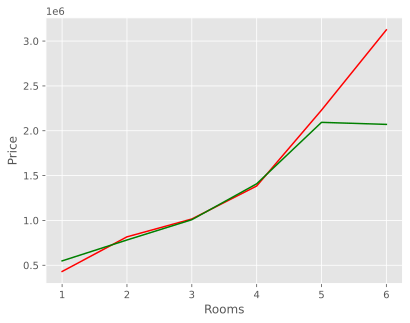

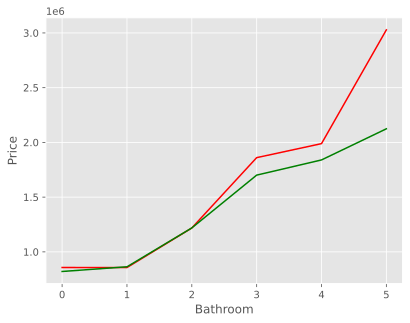

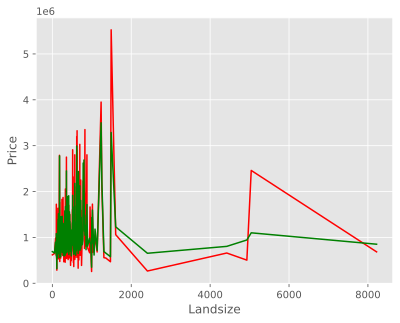

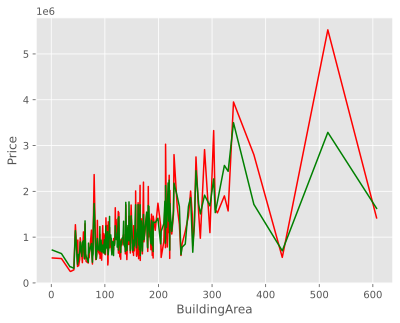

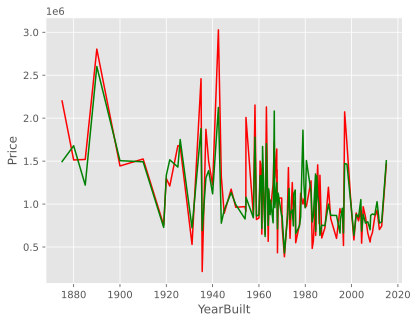

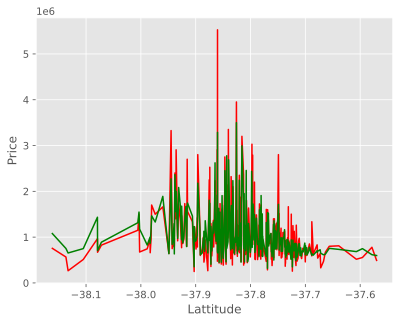

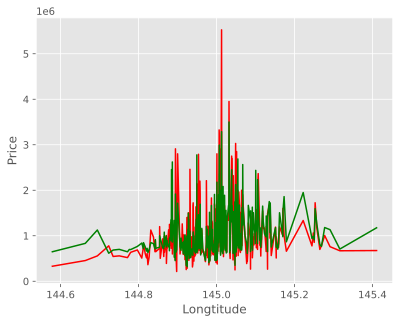

In [19]:
for col in features:
    _=plt.figure()
    # _=sns.lineplot(data=val_X,x=col,y=val_y, alpha=1,errorbar=None,palette=['red'])
    # _=sns.lineplot(data=val_X,x=col,y=preds, alpha=1,errorbar=None,palette=['green'])
    _=sns.lineplot(data=val_X,x=col,y=val_y, alpha=1,errorbar=None,color='red')
    _=sns.lineplot(data=val_X,x=col,y=preds, alpha=1,errorbar=None,color='green')